In [1]:
#pip install mlxtend

1. Loading the dataset: Load the data and import the libraries.
2. Data Preprocessing:
    2.1. Analysing missing data
    2.2. Removing redundant columns.
3. Visualising and counting sentiments of tweets for each airline
4. Wordcloud plots for positive and negative tweets to visualise most frequent words for each.
5. Analysing the reasons for negative tweets for each airline.
6. Visualising negative tweet-sentiment relationship with dates.
7. Predicting the tweet sentiments with tweet text data with:
    7.1. Decision Tree Classifier
    7.2. Random Forest Classifier
8. Calculating accuracies, plotting the confusion matrix and comparing the models.


### 1. Importing the libraries and loading the data¶

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("input"))
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
# Any results you write to the current directory are saved as output.

['Tweets.csv']


In [3]:
df= pd.read_csv("Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,24-02-2015 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,24-02-2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,24-02-2015 11:14,NaN,Pacific Time (US & Canada)


### 2. Data Preprocessing 

The first step should be to check the shape of the dataframe and then check the number of null values in each column.

In this way we can get an idea of the redundant columns in the data frame depending on which columns have the highest number of null values.

In [4]:
print("Shape of the dataframe is",df.shape)
print("The number of nulls in each column are \n", df.isna().sum())

Shape of the dataframe is (14640, 15)
The number of nulls in each column are 
 tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


To get a better idea, lets calculate the percentage of nulls or NA values in each column

In [5]:
print("Percentage null or na values in df")
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

Percentage null or na values in df


tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

tweet_coord , airline_sentiment_gold, negativereason_gold have more than 90% missing data. It will be better to delete these columns as they will not provide any constructive information.

In [6]:
del df['tweet_coord']
del df['airline_sentiment_gold']
del df['negativereason_gold']
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,24-02-2015 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,24-02-2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,24-02-2015 11:14,NaN,Pacific Time (US & Canada)


#### Airline sentiments for each airline

1. Firstly lets calculate the total number of tweets for each airline
2. Then, we are going to get the barplots for each airline with respect to sentiments of tweets (positive,negative or neutral).
3. This will give us a clearer idea about the airline sentiments , airlines relationship.

Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


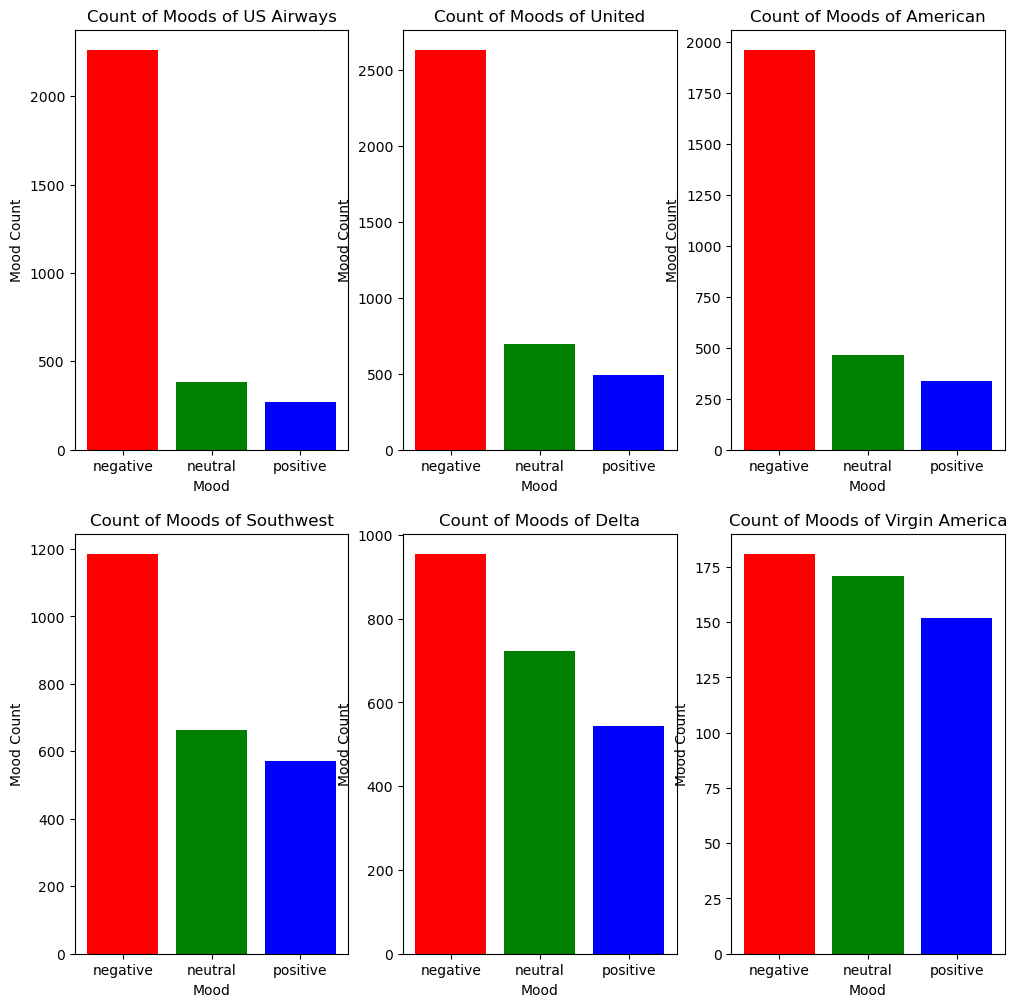

In [7]:
print("Total number of tweets for each airline \n ",df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=df[df['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

- United, US Airways, American substantially get negative reactions.
- Tweets for Virgin America are the most balanced.

#### Most used words in Positive and Negative tweets

In [8]:
#pip install wordcloud

In [9]:
from wordcloud import WordCloud,STOPWORDS

- The goal is to firstly get an idea of the most frequent words in negative tweets.
- Get idea about most frequent words in positive tweets.

#### Wordcloud for Negative sentiments of tweets

Wordcloud is a great tool for visualizing nlp data. The larger the words in the wordcloud image, the more is the frequency of that word in our text data.

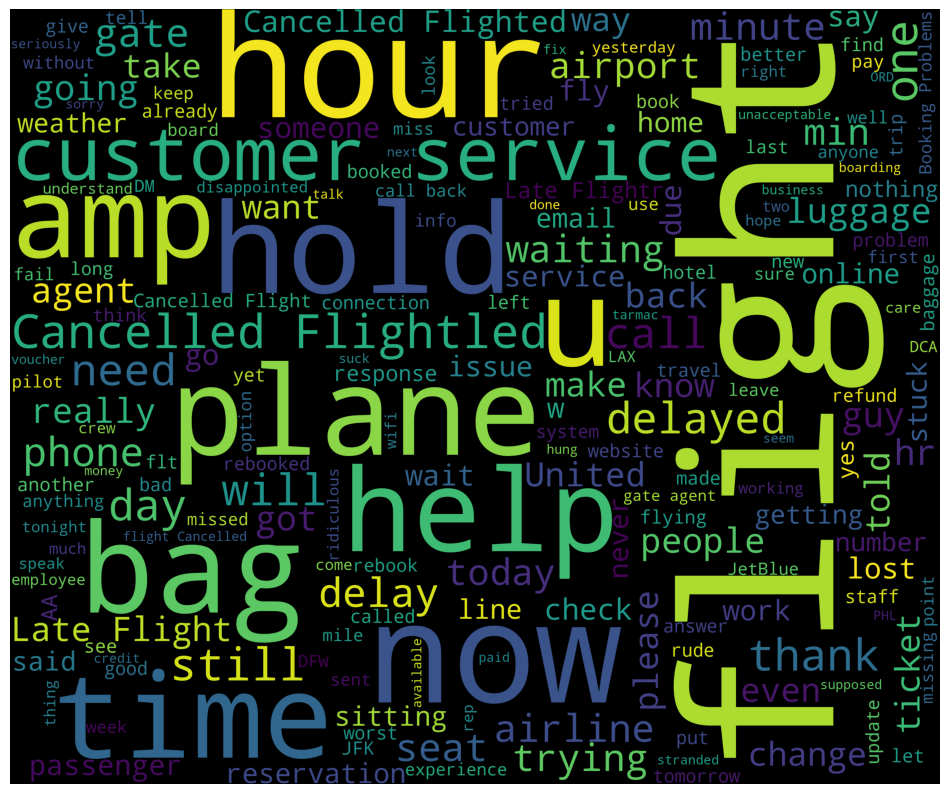

In [10]:
new_df=df[df['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Wordcloud for positive reasons 

The code for getting positive sentiments is completely same with the one for negative sentiments. Just replace negative with positive in the first line. Easy, right!

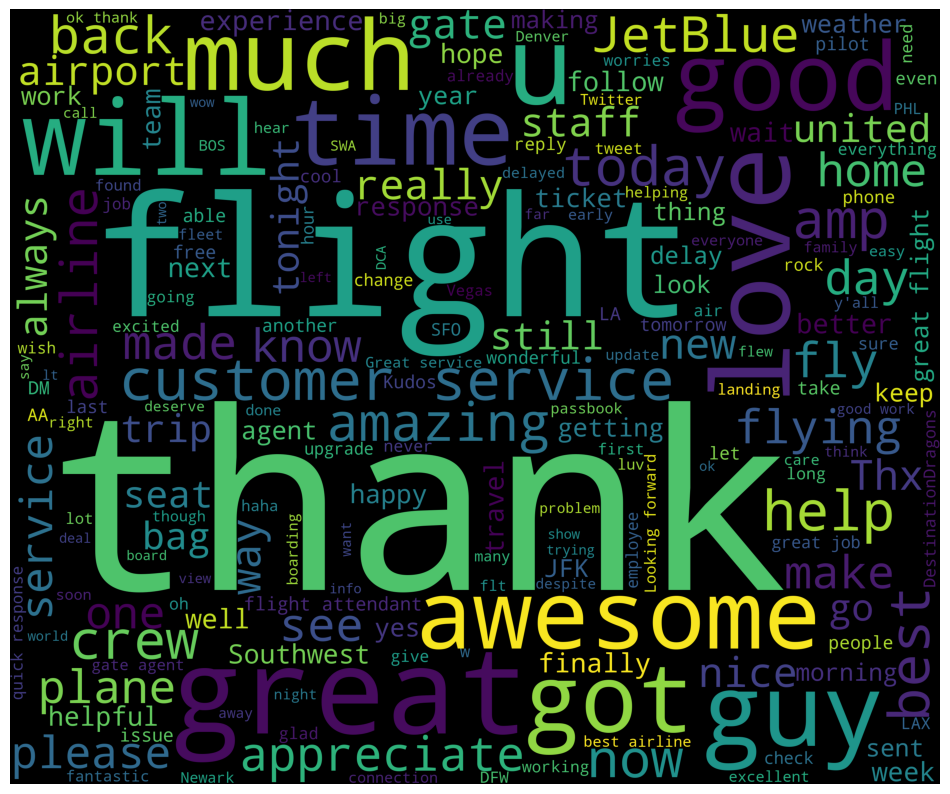

In [11]:
new_df=df[df['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


Calculate the highest frequency words in postive sentimental tweets

In [12]:
# Calculate highest frequency words in positive tweets
def freq(str): 
  
    # break the string into list of words  
    str = str.split()          
    str2 = [] 
  
    # loop till string values present in list str 
    for i in str:              
  
        # checking for the duplicacy 
        if i not in str2: 
  
            # insert value in str2 
            str2.append(i)  
              
    for i in range(0, len(str2)): 
        if(str.count(str2[i])>50): 
            print('Frequency of', str2[i], 'is :', str.count(str2[i]))
        
print(freq(cleaned_word))

Frequency of to is : 923
Frequency of the is : 924
Frequency of time is : 59
Frequency of I is : 574
Frequency of fly is : 54
Frequency of this is : 143
Frequency of :) is : 96
Frequency of it is : 166
Frequency of was is : 226
Frequency of and is : 416
Frequency of an is : 74
Frequency of good is : 75
Frequency of so is : 163
Frequency of much is : 54
Frequency of is is : 219
Frequency of a is : 501
Frequency of great is : 144
Frequency of my is : 320
Frequency of &amp; is : 77
Frequency of on is : 327
Frequency of I'm is : 67
Frequency of flying is : 59
Frequency of your is : 212
Frequency of all is : 92
Frequency of from is : 124
Frequency of Thanks! is : 69
Frequency of for is : 658
Frequency of flight is : 263
Frequency of but is : 91
Frequency of you is : 509
Frequency of would is : 56
Frequency of be is : 135
Frequency of with is : 195
Frequency of you. is : 77
Frequency of love is : 85
Frequency of You is : 62
Frequency of are is : 120
Frequency of of is : 236
Frequency of that

- Words like Thanks, best, customer , love, flying , good are understandably present in the most frequent words of positive tweets.
- However, other than these, most of the words are stop words and need to be filtered. We will do so later.
- Lets try and visualize the reasons for negative tweets first !!

#### What are the reasons for negative sentimental tweets for each airline ?

We will explore the negative reason column of our dataframe to extract conclusions about negative sentiments in the tweets by the customers

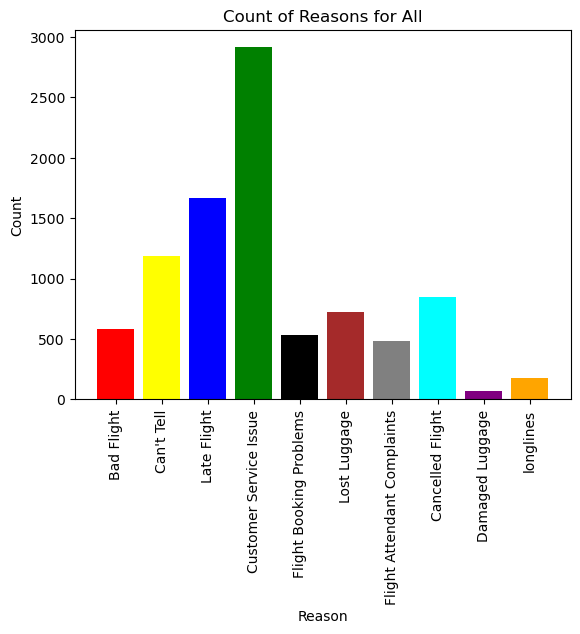

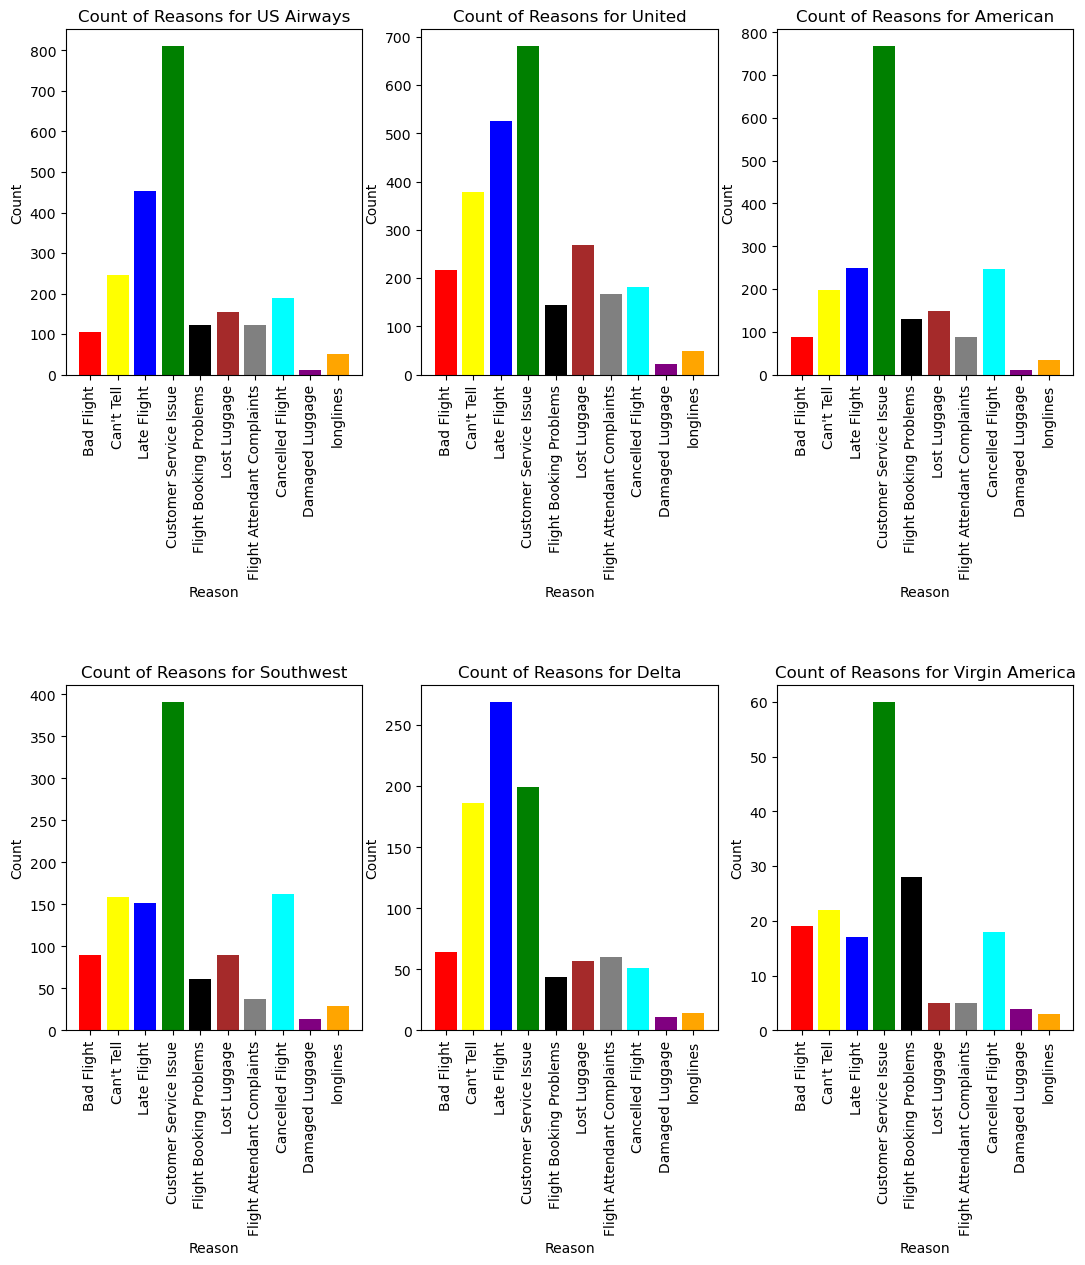

In [13]:
#get the number of negative reasons
df['negativereason'].nunique()

NR_Count=dict(df['negativereason'].value_counts(sort=False))
def NR_Count(Airline):
    if Airline=='All':
        a=df
    else:
        a=df[df['airline']==Airline]
    count=dict(a['negativereason'].value_counts())
    Unique_reason=list(df['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame

def plot_reason(Airline):
    
    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count, color=['red','yellow','blue','green','black','brown','gray','cyan','purple','orange'])
    plt.xticks(Index,a['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)
    
plot_reason('All')
plt.figure(2,figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

- Customer Service Issue is the main neagtive reason for US Airways,United,American,Southwest,Virgin America
- Late Flight is the main negative reason for Delta
- Interestingly, Virgin America has the least count of negative reasons (all less than 60)
- Contrastingly to Virgin America, airlines like US Airways,United,American have more than 500 negative reasons (Late flight, Customer Service Issue)

#### Is there a relationship between negative sentiments and date ? 

- Our dataframe has data from 2015-02-17 to 2015-02-24

- It will be interesting to see if the date has any effect on the sentiments of the tweets(especially negative !). We can draw various coclusions by visualizing this.

In [14]:
date = df.reset_index()
#convert the Date column to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
df = date
day_df = df.groupby(['tweet_created','airline','airline_sentiment']).size()
# day_df = day_df.reset_index()
day_df

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative             108
                               neutral               86
                                                   ... 
2015-02-24     United          neutral               49
                               positive              25
               Virgin America  negative              10
                               neutral                6
                               positive              13
Length: 136, dtype: int64

- This shows the sentiments of tweets for each date from 2015-02-17 to 2015-02-24 for every airline in our dataframe.

- Our next step will be to plot this and get better visualization for negative tweets.

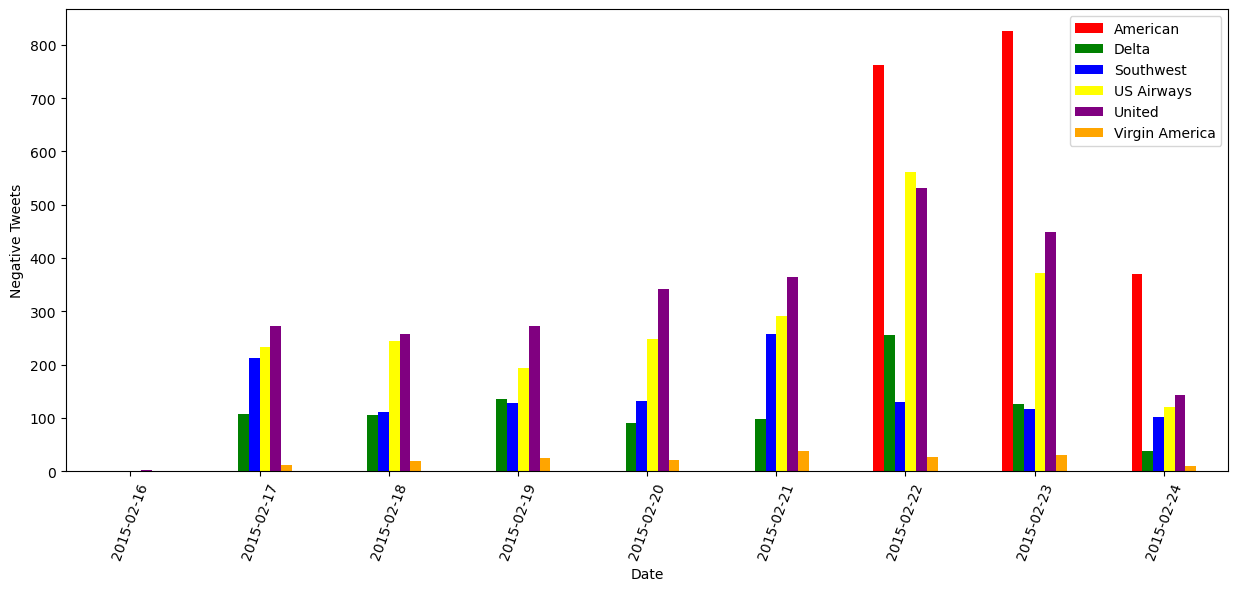

In [15]:
day_df = day_df.loc(axis=0)[:,:,'negative']

#groupby and plot data
ax2 = day_df.groupby(['tweet_created','airline']).sum().unstack().plot(kind = 'bar', color=['red', 'green', 'blue','yellow','purple','orange'], figsize = (15,6), rot = 70)
labels = ['American','Delta','Southwest','US Airways','United','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()

- Interestingly, American has a sudden upsurge in negative sentimental tweets on 2015-02-23, which reduced to half the very next day 2015-02-24. (I hope American is doing better these days and resolved their Customer Service Issue as we saw before)
- Virgin America has the least number of negative tweets throughout the weekly data that we have. It should be noted that the total number of tweets for Virgin America was also significantly less as compared to the rest airlines, and hence the least negative tweets.
- The negative tweets for all the rest airlines is slightly skewed towards the end of the week !

#### Preprocessing the tweet text data 

Clean the tweet text data and apply classification algorithms on it.

In [27]:
#from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ", tweet) 
    words = letters_only.lower().split()                             
    #stops = set(stopwords.words("english"))
    stops = set(ENGLISH_STOP_WORDS)
    meaningful_words = [w for w in words if not w in stops] 
    return " ".join(meaningful_words)

df['clean_tweet'] = df['text'].apply(tweet_to_words)

The data is split in the standard 80,20 ratio.

In [28]:
train,test = train_test_split(df,test_size=0.2,random_state=42)

In [31]:
train_clean_tweet=[]
for tweet in train['clean_tweet']:
    train_clean_tweet.append(tweet)
test_clean_tweet=[]
for tweet in test['clean_tweet']:
    test_clean_tweet.append(tweet)

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(train_clean_tweet)
test_features=v.transform(test_clean_tweet)

### Prediciting sentiments from tweet text data

- Decision Tree Classifier
- Random Forest Classifier

In [33]:
Classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200)]

In [35]:
dense_features=train_features.toarray()
dense_test= test_features.toarray()
Accuracy=[]
Model=[]

Accuracy of DecisionTreeClassifier is 0.671448087431694
              precision    recall  f1-score   support

    negative       0.75      0.81      0.78      1741
     neutral       0.49      0.40      0.44       725
    positive       0.57      0.57      0.57       462

    accuracy                           0.67      2928
   macro avg       0.61      0.59      0.60      2928
weighted avg       0.66      0.67      0.66      2928



<Figure size 640x480 with 0 Axes>

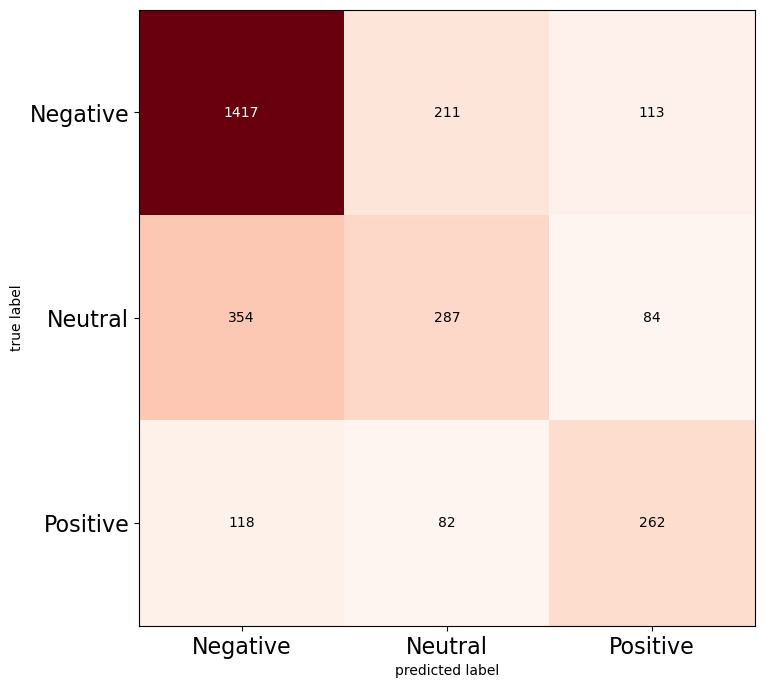

Accuracy of RandomForestClassifier is 0.7657103825136612
              precision    recall  f1-score   support

    negative       0.89      0.83      0.86      2028
     neutral       0.50      0.56      0.53       510
    positive       0.61      0.72      0.66       390

    accuracy                           0.77      2928
   macro avg       0.66      0.70      0.68      2928
weighted avg       0.78      0.77      0.77      2928



<Figure size 640x480 with 0 Axes>

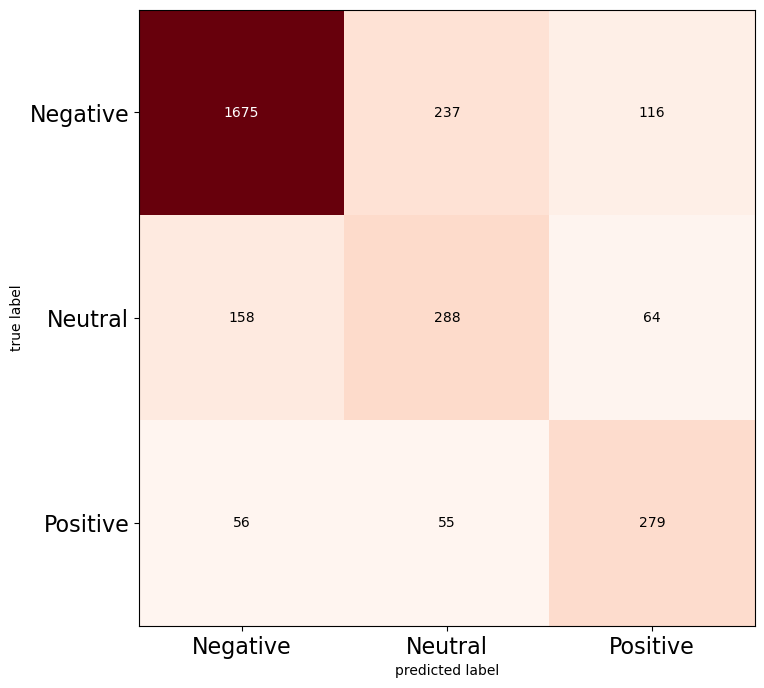

In [37]:
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features, train['airline_sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features, train['airline_sentiment'])
        pred = fit.predict(dense_test)
    
    accuracy = accuracy_score(pred, test['airline_sentiment'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    
    print('Accuracy of ' + classifier.__class__.__name__ + ' is ' + str(accuracy))
    print(classification_report(pred, test['airline_sentiment']))
    
    cm = confusion_matrix(pred, test['airline_sentiment'])
    
    # Set the correct number of tick locations and labels
    tick_labels = ['Negative', 'Neutral', 'Positive']
    tick_locations = np.arange(len(tick_labels))
    
    plt.figure()
    plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True, cmap=plt.cm.Reds)
    plt.xticks(tick_locations, tick_labels, fontsize=16, color='black')
    plt.yticks(tick_locations, tick_labels, fontsize=16)
    plt.show()

- As we you can see above we have plotted the confusion matrix for predicted sentiments and actual sentiments (negative,neutral and positive)
- Random Forest Classifier gives us the best accuracy score, precision scores according to the classification report.
- The confusion matrix shows the TP,TN,FP,FN for all the 3 sentiments(negative,neutral and positive),Here also Random Forest Classifier gives better results than the Decision Tree Classifier.